###*Mount the Drive*###

In [9]:
#This mounts the google drive to the Colab VM
from google.colab import drive

drive.mount('/content/drive')

#This is the name of the folder where the ipynb file
FOLDERNAME = 'cvdl/Project/Main Model'

#Here, we're adding the folder to the path
import sys

sys.path.append("/content/drive/My Drive/{}".format(FOLDERNAME))

Mounted at /content/drive


#*Model Architecture*#

The model of this facial expression recognition is as follows:

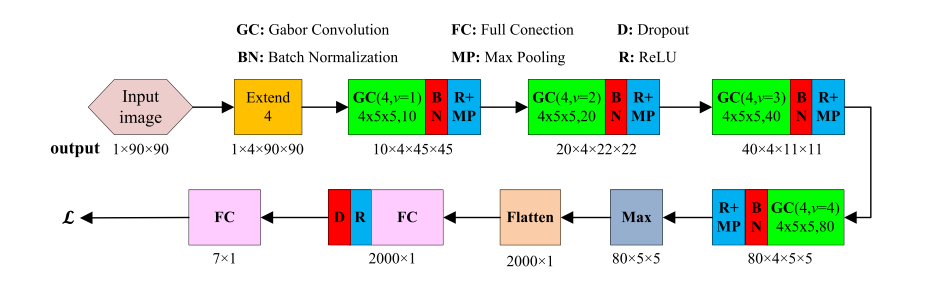

This architecture consists of 4 cascaded convolutional layers, followed by 2 fully connected layers alongside some non-linearities: ReLU and MaxPooling.

In fact, the original model use Gabor Convolutional Layers that should be downloaded from another GitHub repo: https://github.com/jxgu1016/Gabor_CNN_PyTorch. However, we could not download and use these GC layers despite following their ReadMe files to the letter. 
Luckily, the authors also published a subfolder where they used their models with normal Convolutional Layers instead of Gabor Convolutional Layers and these worked just fine.

In this jupyter notebook, we will be reproducing the results the original authors obtained while completing their research before extending it and expand its usecase. 

###*Imports*###

In this model, they used multiple Python pacakages imported below:

In [10]:
!pip install tensorboardX

import time
import torch
from PIL import Image
from net_factory import GCN_mod
import matplotlib.pyplot as plt 
import torch.nn.functional as F
import torch.utils.data as Data
from utils import (AverageMeter, accuracy)
from torchvision import datasets, transforms 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###*Loading the Model*###

In [7]:
def load_model(model_name, gpu=0):
    """

    Parameters
    ----------
    model_name : TYPE
        DESCRIPTION.

    Returns
    -------
    model : TYPE
        DESCRIPTION.

    """

    model = GCN_mod(channel=4, lych=10)
    if gpu:
      try:
        model.load_state_dict(torch.load(model_name))
        print ('gpu')
      except:
        gpu=0
    if not gpu:
      model.load_state_dict(torch.load(model_name, map_location=torch.device('cpu')))
      print('cpu')
    model.eval()

    return model

###*Loading Test Image*###

The trained model needs for input a *90x90* image, that is why, after loading the image, we are resizing it automatically to a 90x90 to avoid any runtime errors.

In [13]:
def load_image(image_name):
    """
    Parameters
    ----------
    image_name : TYPE
        DESCRIPTION.

    Returns
    -------
    image : TYPE
        DESCRIPTION.
    """
    img = Image.open(image_name)

    #We added this resizing function since the model only works for 100x100 images and running the code generated errors without it
    img = img.resize((100,100))
    
    return img

##*Testing the model on one picture*##

In [3]:
def predict(model, image):
    """
    Parameters
    ----------
    model : TYPE
        DESCRIPTION.
    img : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    #Images Transforms
    transform = transforms.Compose([
        transforms.Grayscale(1),        
        transforms.TenCrop(90),  
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),    
        ])

    timg = transform(image)
    with torch.no_grad():
        score = model(timg)

    score = score.mean(dim=0)
    
    #Finding the maximum between the probabilities, and classifying the image into one category
    emotion = torch.argmax(score)

    return emotion


# To test the model, we imported the model trained on the RAF dataset (http://www.whdeng.cn/raf/model1.html).
And we imported a random image:

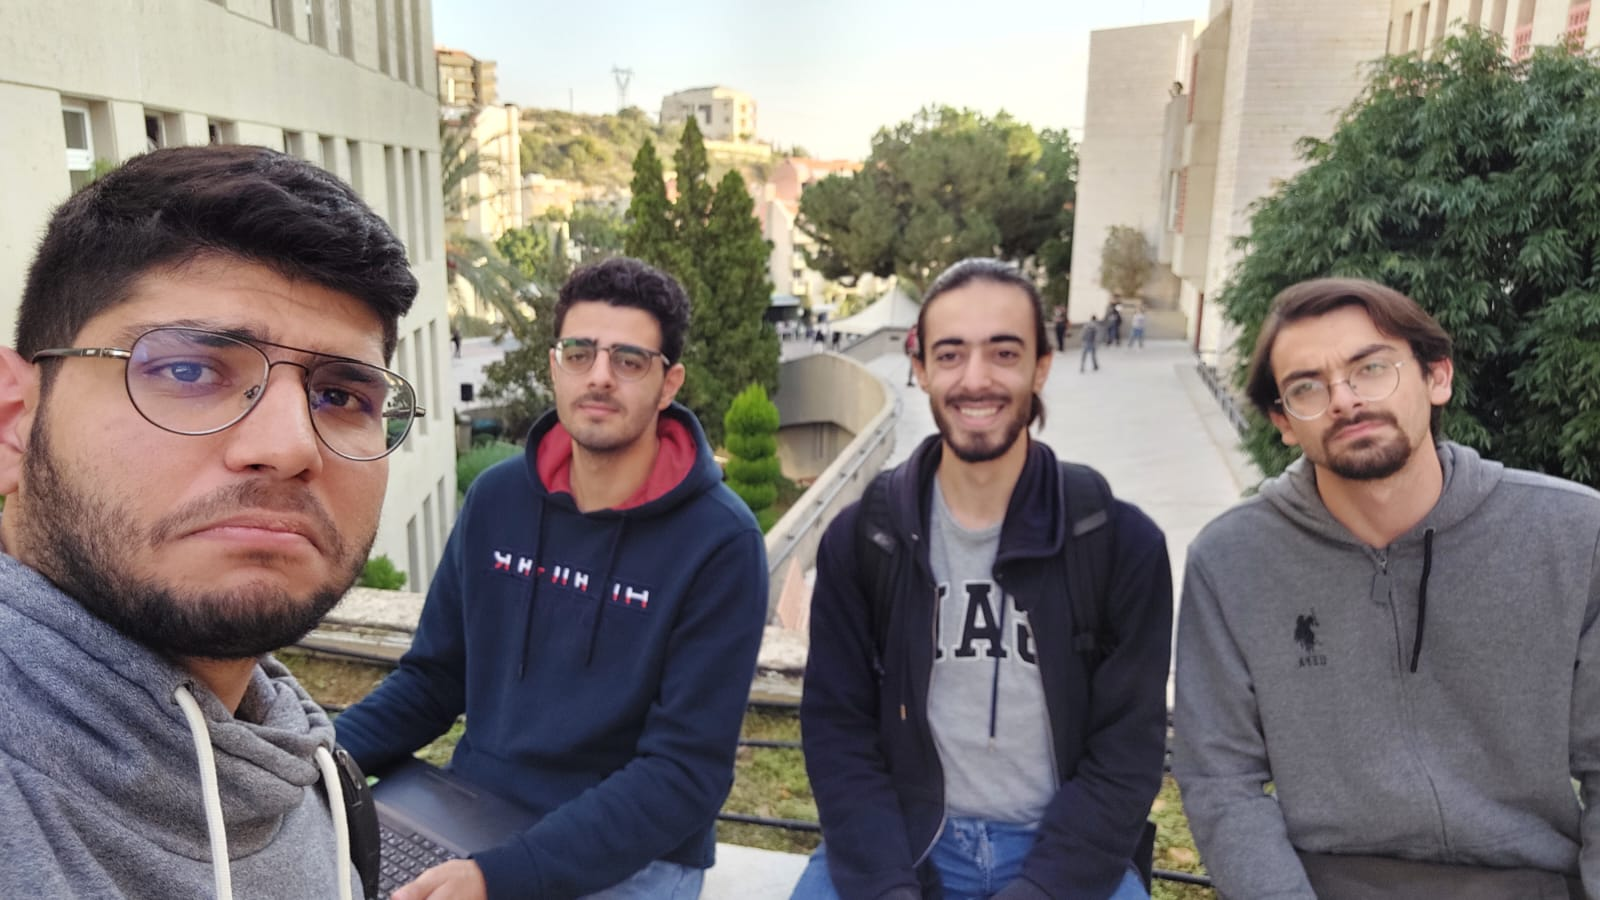

We imported this image because it contained 4 persons to stress test this model and check for its limitations.

In [11]:
#Load the Model
model = load_model('/content/drive/MyDrive/cvdl/Project/Main Model/trained_RAF_10.pt', True)

"""
recognition result
Anger:     0
Dsigust:   1
Fear:      2
Happy:     3
Netural:   4
Sadness:   5
Surprise:  6
"""
emotions = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

gpu


##*Testing Model's Limitation*##


expression class for the previously shown image is 5 : Sadness


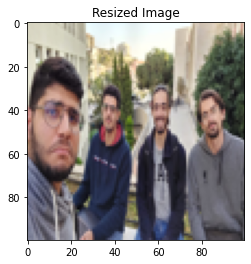

In [12]:
"""
Test #1: 
Multiple faces in the frame
"""
#Load the images
image = load_image('/content/drive/MyDrive/cvdl/Project/Main Model/Images/4 people.jpeg')
plt.title("Resized Image", fontfamily='calibri', loc='center', fontsize='large')
plt.imshow(image)

#Predict on this image
emo = predict(model, image)
print("expression class for the previously shown image is", int(emo), ':', emotions[emo])

expression class for the previously shown image is: 0 - Anger


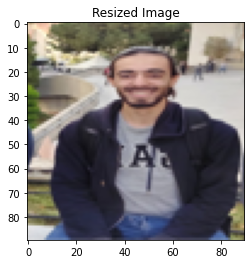

In [108]:
"""
Test #2: 
Single face in the frame, but not cropped
"""
#Load the images
image = load_image('/content/drive/MyDrive/cvdl/Project/Main Model/Images/Cropped - far.jpeg')
plt.title("Resized Image", fontfamily='calibri', loc='center', fontsize='large')
plt.imshow(image)

#Predict on this image
emo = predict(model, image)
print("expression class for the previously shown image is:", int(emo), '-', emotions[emo])

expression class for image 1 is: 3 - Happy
expression class for image 2 is: 4 - Neutral
expression class for image 3 is: 4 - Neutral
expression class for image 4 is: 1 - Disgust


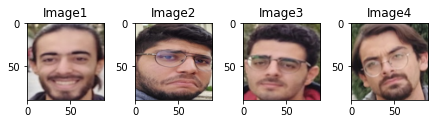

In [109]:
"""
Test #3: 
Single face in the frame, and cropped
the four faces in the image from test1 will be tested
"""
#Load the images
images = [0,0,0,0]
fig, ax = plt.subplots(1,4)
fig.tight_layout(pad=0)
for i in range (4):
  images[i] = load_image('/content/drive/MyDrive/cvdl/Project/Main Model/Images/Cropped'+str(i+1)+'.jpeg')
  ax[i].imshow(images[i]) 
  ax[i].set_title('Image'+str(i+1)+'', fontfamily='calibri', loc='center', fontsize='large')

  #Predict on th image
  emo = predict(model, images[i])
  print("expression class for image", i+1 ,"is:", int(emo), '-', emotions[emo])

###*Observations*###
From these predictions, we can clearly see that one of the limitations of this model is that it cannot predict emotions if multiple persons are in the image (test #1 should return 4 emotions, only returned 1)

Another limitation is that the model works badly when only one person is in the frame when the image is not cropped over their faces (test #2 should be happy, it returned angry)

For our last test, we tested each of the faces that depicts different emotions, sequentially: happy, sad, neutral, disgust; it returned three of the four emotions correctly. It misclassified the sad emotion for neutral. 
We tested offline other sad images, it almost always detected them as neutral. Thus the model is biased towards neutrality when sadness is shown. 
One solution could be to retrain the model with a bigger and more varied 'Sad' dataset.

Based on this, we can say that me model is fairly accurate once the image is pre-processed. However, these samples are not enough to generate accurate observations. 


##*Testing the model on a testing dataset*##


We also tested using their testing method done for the RAF dataset on the FER2013 (https://www.kaggle.com/datasets/msambare/fer2013) since we were not able to get the RAF dataset in time: it required the permission of the owners who did not reply with the passkey to access the files.

Additionally, testing the model with a different dataset could showcase a stress-testing method to see how the model would work for random images.

In [110]:
def test_model(model, dataset):
    """
    Parameters
    ----------
    model : TYPE
        DESCRIPTION.
    img : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    #Images Transforms
    transform =  transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize(100),
        transforms.TenCrop(90),  
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),    
    ])

    data_dir = dataset
    image_datasets = datasets.ImageFolder(data_dir + 'test', transform)
    test_loader = Data.DataLoader(dataset = image_datasets, batch_size = 256)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = model.to(device)
    
    def test():
        model.eval()
        y_test = []
        y_pred = []
        test_loss = AverageMeter()
        acc = AverageMeter()
        with torch.no_grad():
            for data, target in test_loader:
                bs, ncrops, c,h,w = data.size()
                data = data.view(-1,c,h,w)
                data, target = data.to(device), target.to(device)
                output = model(data) 
                output = output.view(bs,ncrops,-1).mean(1)
                test_loss.update(F.cross_entropy(output, target, reduction='mean').item(), target.size(0))
                prec1, = accuracy(output, target) # test precison in one batch
                acc.update(prec1.item(), target.size(0))
        print('\nTest set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(test_loss.avg, acc.avg))
        return acc.avg, y_test, y_pred
    st = time.time()
    prediction, y_test, y_pred = test() 
    epoch_time = time.time() - st
    print('Accuracy is: %.2f%%' %prediction)
    print('Test time:{:0.2f}s'.format(epoch_time))

In [111]:
#Load the Model
model = load_model('/content/drive/MyDrive/cvdl/Project/Main Model/trained_RAF_10.pt', True)

#Dataset Directory
dir = '/content/drive/MyDrive/cvdl/Project/Main Model/Images/FER/'

test_model(model, dir)

gpu

Test set: Average loss: 2.9649, Accuracy: 53.90%
Accuracy is: 53.90%
Test time:32.83s


##*Observations:*##

This model resulted in a lower accuracy (54%) than the accuracy obtained in the journal article due to the fact that:

1) we used the normla CNN instead of the Gabor one. 

2) we used a pre-trained model trained only on the RAF dataset while using the testing images of the FER dataset.

##*Improvements:*##

Based on what we demonstrated in this *.ipynb* file, we found that we could improve the use of the model and make it easier to run if we have a pre-processing step.

#####*Pre-Processing*####
This pre-processing step is crucial since we are aiming at a real time emotion detection.
In the real-time feed, the user will not bother centering the aimed face in the middle of the frame. Thus, this pre-processing step is crucial. 
In addition to this, we need to be sure to detect the emotions of different persons if they're all shown in the frame.

**To check the improvements we added to this model, please refer to the following link:**  https://colab.research.google.com/drive/1a5jMAbBWRxtMlb_SSUPZJyT2NKt1KOAY

#*References*#

* https://ieeexplore-ieee-org.ezproxy.lau.edu.lb:2443/stamp/stamp.jsp?tp=&arnumber=9226082

* https://github.com/general515/Facial_Expression_Recognition_Using_GCN

* https://github.com/jxgu1016/Gabor_CNN_PyTorch

* http://www.whdeng.cn/raf/model1.html

* https://www.kaggle.com/datasets/msambare/fer2013
